# Risk Premia in REITs and its application in a quantitative value strategy

##### Dissertation for Master's degree in Economics from [Insper](https://www.insper.edu.br/en/graduate/masters-of-science/)

##### Advisor: [Prof. Dr. Gustavo B. Soares](https://github.com/gustavobsoares/) ([CV](http://lattes.cnpq.br/8491228979459078))
##### Student: Lucas L. Sanches ([Resume](http://lattes.cnpq.br/2528322802099316))

# Strategy Notebook

### Imports

In [1]:
from utils.database import *

In [2]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
from statsmodels.regression.rolling import RollingOLS
from tqdm import tqdm
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline

### Strategies

Considering 3 lags in our monthly data (AR(3) model on more than 20 years of data), we reject the null hypothesis of no cointegration at 1% significance level; thus, at least 2 of our series are cointegrated and it makes sense to build a mean reversion strategy with them.

In [3]:
st_date = START_DATES['SPXFP Index']
x = data[['BBREIT Index','SPXFP Index', 'SPUSTTP Index']].loc[data.index>st_date].resample('M').last()
jres = coint_johansen(x, det_order=0, k_ar_diff=3)
print(jres.eig)
print(jres.evec)
res = select_coint_rank(x, det_order=0, k_ar_diff=3, signif=0.01)
res.summary()

[9.85108796e-02 2.38523454e-02 4.69602563e-06]
[[ 0.66713997 -1.09945736  0.02843101]
 [-2.30490274  2.11537348 -2.02652466]
 [-3.96925289  4.00665042  2.76722748]]


r_0,r_1,test statistic,critical value
0,3,36.31,35.46
1,3,6.857,19.93


In [4]:
# Retrieving monthly returns starting all at same time
start_date = START_DATES['SPBDU1ST Index']
series = ['BBREIT Index', 'SPXFP Index', 'SPUSTTP Index', 'SPBDU1ST Index']
all_time_series = monthly_data.loc[monthly_data.index>start_date]

In [5]:
# Calculating value metric for REITs based on Equity and Bond Premia

# Betas for positioning
rolling_params_spx = RollingOLS(all_time_series['BBREIT Index'], all_time_series[['SPXFP Index']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params
rolling_params_ust = RollingOLS(all_time_series['BBREIT Index'], all_time_series[['SPUSTTP Index']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params

# Rolling betas for value metric
rolling_params = RollingOLS(all_time_series['BBREIT Index'], all_time_series[['SPXFP Index', 'SPUSTTP Index']],
                            window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params

df_reits_value = pd.concat([rolling_params.iloc[:,:],
                            all_time_series[['SPXFP Index', 'SPUSTTP Index', 'BBREIT Index']]], axis=1).dropna()
df_reits_value.columns = ['Beta SPXFP Index','Beta SPUSTTP Index','SPXFP Index','SPUSTTP Index','BBREIT Index']

df_reits_value['BBREIT IndexValue'] = df_reits_value['Beta SPXFP Index'] * df_reits_value['SPXFP Index'] +\
                                    df_reits_value['Beta SPUSTTP Index'] * df_reits_value['SPUSTTP Index']
df_reits_value['BBREIT IndexValueDiff'] = df_reits_value['BBREIT IndexValue']-df_reits_value['BBREIT Index']

# Data for strategy, with standard deviations on ValueDiff
upper, _, lower = ta.BBANDS(df_reits_value['BBREIT IndexValueDiff'], timeperiod=4, nbdevup=2, nbdevdn=2)
upper_half, _, lower_half = ta.BBANDS(df_reits_value['BBREIT IndexValueDiff'], timeperiod=4, nbdevup=1, nbdevdn=1)

# Build trade signals
df_reits_value['BBREIT IndexSign'] = np.sign((df_reits_value['BBREIT IndexValueDiff']))
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']<lower),'BBREIT IndexSign'] = 0
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=lower)&
                   (df_reits_value['BBREIT IndexValueDiff']<lower_half),'BBREIT IndexSign'] = -1
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=lower_half)&
                   (df_reits_value['BBREIT IndexValueDiff']<upper_half),'BBREIT IndexSign'] = 0
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=upper_half)&
                   (df_reits_value['BBREIT IndexValueDiff']<upper),'BBREIT IndexSign'] = 1
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>upper),'BBREIT IndexSign'] = 0
df_reits_value['BBREIT IndexSign'] = np.sign((df_reits_value['BBREIT IndexSign']).shift(1))

<AxesSubplot:>

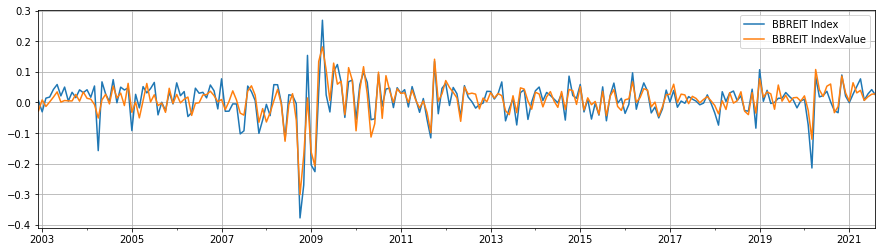

In [6]:
df_reits_value[['BBREIT Index','BBREIT IndexValue']].plot(grid=True,figsize=(15,4))

<AxesSubplot:>

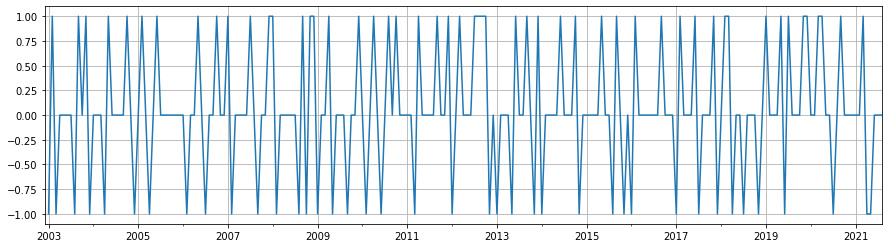

In [7]:
df_reits_value['BBREIT IndexSign'].plot(grid=True,figsize=(15,4))

#### Rolling Value

SPXFP Index        -0.057534
SPUSTTP Index       0.019518
BBREIT IndexSign    0.053571
dtype: float64 

 SPXFP Index         0.653052
SPUSTTP Index       0.878979
BBREIT IndexSign    0.640057
dtype: float64


<AxesSubplot:>

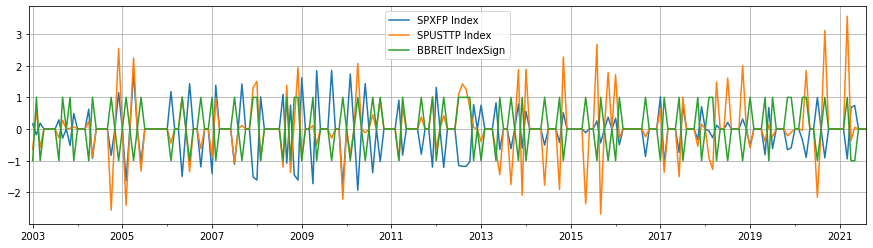

In [8]:
price_change = np.log(data.loc[data.index>df_reits_value.index[0],
                               ['SPXFP Index','SPUSTTP Index','BBREIT Index']]).diff().dropna()
value_signals = df_reits_value[['SPXFP Index', 'SPUSTTP Index', 'BBREIT IndexSign']].copy()
value_signals.loc[:,'SPXFP Index'] = -rolling_params_spx.dropna().shift(1).values
value_signals.loc[:,'SPUSTTP Index'] = -rolling_params_ust.dropna().shift(1).values
value_signals.loc[:,'SPXFP Index'] *= df_reits_value['BBREIT IndexSign'].values
value_signals.loc[:,'SPUSTTP Index'] *= df_reits_value['BBREIT IndexSign'].values

print(value_signals.mean(), '\n\n', value_signals.std())
value_signals.plot(grid=True,figsize=(15,4))

In [9]:
long_reits_months = len(value_signals[value_signals['BBREIT IndexSign']==1])
short_reits_months = len(value_signals[value_signals['BBREIT IndexSign']==-1])
neutral_reits_months = len(value_signals[value_signals['BBREIT IndexSign']==0])
all_reits_months = long_reits_months + short_reits_months + neutral_reits_months

print('Long REITs on '+str(long_reits_months)+' months ('+str(round(100*long_reits_months/all_reits_months,2))+'%)')
print('Short REITs on '+str(short_reits_months)+' months ('+str(round(100*short_reits_months/all_reits_months,2))+'%)')
print('Neutral REITs on '+str(neutral_reits_months)+' months ('+str(round(100*neutral_reits_months/all_reits_months,2))+'%)')

print('\nOn '+str(len(value_signals[abs(value_signals['BBREIT IndexSign'].diff())==2]))+' months, it changes trade side')
print('It is '+str(round(100*len(value_signals[abs(value_signals['BBREIT IndexSign'].diff())==2])/(long_reits_months+short_reits_months),2))+'% of positioned months')

open_months = len(value_signals[value_signals['BBREIT IndexSign']!=0].loc[abs(value_signals['BBREIT IndexSign'].diff())==1])
print('\nOn '+str(open_months)+' months, it opens positions')
print('It is '+str(round(100*open_months/(long_reits_months+short_reits_months),2))+'% of positioned months')

keep_months = len(value_signals[value_signals['BBREIT IndexSign']!=0].loc[abs(value_signals['BBREIT IndexSign'].diff())==0])
print('\nOn '+str(keep_months)+' months, it keeps previous position')
print('It is '+str(round(100*keep_months/(long_reits_months+short_reits_months),2))+'% of positioned months')
      
keep_long_months = len(
    value_signals[value_signals['BBREIT IndexSign']!=0].loc[abs(value_signals['BBREIT IndexSign'].diff())==0].loc[value_signals['BBREIT IndexSign']==1]
)
print('\tOn '+str(keep_long_months)+' of those, it keeps long positions!')
print('\tIt is '+str(round(100*keep_long_months/(keep_months),2))+'% of those positioned months')

Long REITs on 52 months (23.21%)
Short REITs on 40 months (17.86%)
Neutral REITs on 132 months (58.93%)

On 28 months, it changes trade side
It is 30.43% of positioned months

On 54 months, it opens positions
It is 58.7% of positioned months

On 9 months, it keeps previous position
It is 9.78% of positioned months
	On 8 of those, it keeps long positions!
	It is 88.89% of those positioned months


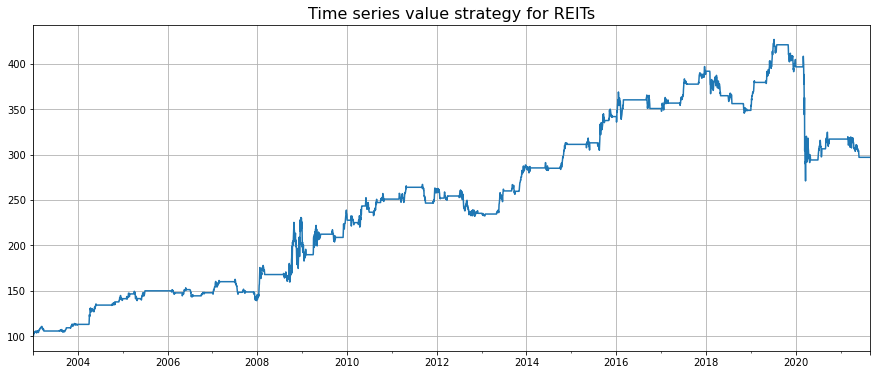

In [10]:
# initial set up, initializing the backtest with 100
backtest = pd.Series(index=price_change.index, dtype=float)
backtest.iloc[0] = 100
value_index = 0
current_index = value_signals.index[value_index]
holdings = value_signals.loc[current_index]

# loop over the next days
for i in range(1, backtest.shape[0]):
    tdy = backtest.index[i]
    
    # calculate pnl on the day
    pnl = 1 + (holdings.values * price_change.loc[tdy]).sum()
    backtest.iloc[i] = backtest.iloc[i-1] * pnl
    
    if tdy.month != current_index.month:
        value_index += 1
        current_index = value_signals.index[value_index]
        holdings = value_signals.loc[current_index]

# plotting the result
backtest.plot(figsize=(15,6), grid=True)
plt.title('Time series value strategy for REITs', fontsize=16)
plt.show()

In [11]:
# Strategy statistics with daily data

print('Excess return:', (backtest[-1] / backtest[0]) ** (252 / (len(backtest) - 1.0)) - 1)
print('Volatility:', np.log(backtest).diff().std()*np.sqrt(252))
print('Sharpe:', ((backtest[-1] / backtest[0]) ** (252 / (len(backtest) - 1.0)) - 1) / (np.log(backtest).diff().std()*np.sqrt(252)))
print('Sortino:', ((backtest[-1] / backtest[0]) ** (252 / (len(backtest) - 1.0)) - 1) / (np.sqrt(252) * (np.log(backtest).diff()[np.log(backtest).diff() < 0.0]).std()))
print('Daily Skew:',(np.log(backtest).diff()).skew())

Excess return: 0.06032536240048669
Volatility: 0.1586596715232384
Sharpe: 0.3802186265818092
Sortino: 0.26698459149939485
Daily Skew: -2.3139071923906114


Min. Month: -0.23193013743789326
Max. Month: 0.1848969429132321
Mean Ann. Return: 0.056825309258396545
Ann. Volatility: 0.1342432417862489
Ann. Sharpe: 0.42330108020542
Ann. Sortino: 0.464781289407364
Max. DD: -0.36530843448933314
Max. DD to Volatility ratio: -2.7212426460246073
Monthly Skew: 0.3098771822402913
Kurtosis: 11.711523331996425


<AxesSubplot:>

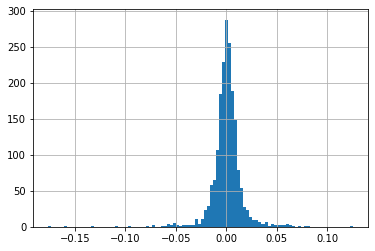

In [12]:
# Strategy statistics with monthly data

print('Min. Month:',(np.log(backtest.resample('M').last()).diff().min()))
print('Max. Month:',(np.log(backtest.resample('M').last()).diff().max()))
print('Mean Ann. Return:',(np.log(backtest.resample('M').last()).diff()).mean()*12)
print('Ann. Volatility:',(np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12))
print('Ann. Sharpe:',(np.log(backtest.resample('M').last()).diff()).mean()*12/((np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12)))
print('Ann. Sortino:',(np.log(backtest.resample('M').last()).diff()).mean()*12/((np.log(backtest.resample('M').last()).diff()[np.log(backtest.resample('M').last()).diff()<0]).std()*np.sqrt(12)))
print('Max. DD:',(backtest/(backtest.expanding(min_periods=1).max())-1).min())
print('Max. DD to Volatility ratio:',(backtest/(backtest.expanding(min_periods=1).max())-1).min()/((np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12)))
# Negative skewness on daily returns, slightly positive on monthly returns!
print('Monthly Skew:',(np.log(backtest.resample('M').last()).diff()).skew())
print('Kurtosis:',(np.log(backtest.resample('M').last()).diff()).kurt())  # Leptokurtic (both daily and monthly)!

backtest_returns = np.log(backtest).diff()
backtest_returns[backtest_returns!=0].hist(bins=100)

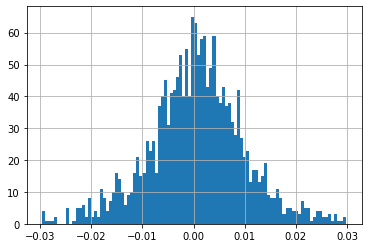

In [13]:
# Mean semester return seems to be +-3%, so let's zoom in this area on our histogram of daily returns
h = backtest_returns[(backtest_returns!=0) & (abs(backtest_returns)<0.03)].hist(bins=100)

In [14]:
print('Positive returns on '+\
      str(round(100*len(backtest_returns[backtest_returns>0])/len(backtest_returns[backtest_returns!=0]),2))+\
      '% of days of non zero return')
print('Negative returns on '+\
      str(round(100*len(backtest_returns[backtest_returns<0])/len(backtest_returns[backtest_returns!=0]),2))+\
      '% of days of non zero return')

Positive returns on 54.03% of days of non zero return
Negative returns on 45.91% of days of non zero return


#### Bootstrapping

In [15]:
# Starting with simple random resample
np.random.seed(42)
er_ts = all_time_series[['BBREIT Index','SPXFP Index','SPUSTTP Index']]
block_size=6  # 6-month bootstrap block samples
T = er_ts.shape[0]
bootstrap_sample = pd.DataFrame()
while bootstrap_sample.shape[0]<T:
    pick_random_t = np.random.randint(0,T-block_size)
    block_picked = ((er_ts.iloc[pick_random_t:pick_random_t+block_size]).reset_index().drop('index',1))
    bootstrap_sample = bootstrap_sample.append(block_picked)
bootstrap_sample = bootstrap_sample.iloc[:T]
bootstrap_sample.index = er_ts.index

In [16]:
# Calculating value metric, betas and trade signals again

rolling_params_spx = RollingOLS(bootstrap_sample['BBREIT Index'], bootstrap_sample[['SPXFP Index']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params
rolling_params_ust = RollingOLS(bootstrap_sample['BBREIT Index'], bootstrap_sample[['SPUSTTP Index']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params

rolling_params = RollingOLS(bootstrap_sample['BBREIT Index'], bootstrap_sample[['SPXFP Index', 'SPUSTTP Index']],
                            window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params

df_reits_value = pd.concat([rolling_params.iloc[:,:],
                            bootstrap_sample[['SPXFP Index', 'SPUSTTP Index', 'BBREIT Index']]], axis=1).dropna()
df_reits_value.columns = ['Beta SPXFP Index','Beta SPUSTTP Index','SPXFP Index','SPUSTTP Index','BBREIT Index']

df_reits_value['BBREIT IndexValue'] = df_reits_value['Beta SPXFP Index'] * df_reits_value['SPXFP Index'] +\
                                    df_reits_value['Beta SPUSTTP Index'] * df_reits_value['SPUSTTP Index']
df_reits_value['BBREIT IndexValueDiff'] = df_reits_value['BBREIT IndexValue']-df_reits_value['BBREIT Index']

upper, _, lower = ta.BBANDS(df_reits_value['BBREIT IndexValueDiff'], timeperiod=4, nbdevup=2, nbdevdn=2)
upper_half, _, lower_half = ta.BBANDS(df_reits_value['BBREIT IndexValueDiff'], timeperiod=4, nbdevup=1, nbdevdn=1)

df_reits_value['BBREIT IndexSign'] = np.sign((df_reits_value['BBREIT IndexValueDiff']))
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']<lower),'BBREIT IndexSign'] = 0
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=lower)&
                   (df_reits_value['BBREIT IndexValueDiff']<lower_half),'BBREIT IndexSign'] = -1
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=lower_half)&
                   (df_reits_value['BBREIT IndexValueDiff']<upper_half),'BBREIT IndexSign'] = 0
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=upper_half)&
                   (df_reits_value['BBREIT IndexValueDiff']<upper),'BBREIT IndexSign'] = 1
df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>upper),'BBREIT IndexSign'] = 0
df_reits_value['BBREIT IndexSign'] = np.sign((df_reits_value['BBREIT IndexSign']).shift(1))

In [17]:
price_change = np.log(data.loc[data.index>df_reits_value.index[0],
                               ['SPXFP Index','SPUSTTP Index','BBREIT Index']]).diff().dropna()
value_signals = df_reits_value[['SPXFP Index', 'SPUSTTP Index', 'BBREIT IndexSign']].copy()
value_signals.loc[:,'SPXFP Index'] = -rolling_params_spx.dropna().shift(1).values
value_signals.loc[:,'SPUSTTP Index'] = -rolling_params_ust.dropna().shift(1).values
value_signals.loc[:,'SPXFP Index'] *= df_reits_value['BBREIT IndexSign'].values
value_signals.loc[:,'SPUSTTP Index'] *= df_reits_value['BBREIT IndexSign'].values

In [18]:
# initial set up, initializing the backtest with 100
backtest = pd.Series(index=price_change.index, dtype=float)
backtest.iloc[0] = 100
value_index = 0
current_index = value_signals.index[value_index]
holdings = value_signals.loc[current_index]

# loop over the next days
for i in range(1, backtest.shape[0]):
    tdy = backtest.index[i]
    
    # calculate pnl on the day
    pnl = 1 + (holdings.values * price_change.loc[tdy]).sum()
    backtest.iloc[i] = backtest.iloc[i-1] * pnl
    
    if tdy.month != current_index.month:
        value_index += 1
        current_index = value_signals.index[value_index]
        holdings = value_signals.loc[current_index]

Min. Month: -0.09125725885572677
Max. Month: 0.1639889504327421
Mean Ann. Return: 0.0196420020531894
Ann. Volatility: 0.09581753383188432
Ann. Sharpe: 0.20499381759973154
Daily Skew: -0.5930287778436786
Monthly Skew: 1.4167120414601746
Kurtosis: 9.087221338540726


<AxesSubplot:>

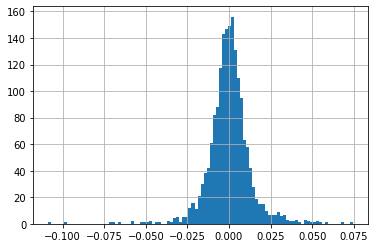

In [19]:
print('Min. Month:',(np.log(backtest.resample('M').last()).diff().min()))
print('Max. Month:',(np.log(backtest.resample('M').last()).diff().max()))
print('Mean Ann. Return:',(np.log(backtest.resample('M').last()).diff()).mean()*12)
print('Ann. Volatility:',(np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12))
print('Ann. Sharpe:',(np.log(backtest.resample('M').last()).diff()).mean()*12/((np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12)))
print('Daily Skew:',(np.log(backtest).diff()).skew())
print('Monthly Skew:',(np.log(backtest.resample('M').last()).diff()).skew())
print('Kurtosis:',(np.log(backtest.resample('M').last()).diff()).kurt())  # Leptokurtic (both daily and monthly)!

backtest_returns = np.log(backtest).diff()
backtest_returns[backtest_returns!=0].hist(bins=100)

When analysing the boostrapped results, it seems that we might have some overfitting in our strategy... When we change a little the series of returns, things sometimes get messy; however for some block sizes we still have positive results:

- 3-year bootstrap block:

    - Min. Month: -0.1766
    - Max. Month: 0.1601
    - Mean Ann. Return: -0.0340
    - Ann. Volatility: 0.1302
    - Ann. Sharpe: -0.2614
    - Daily Skew: -0.7889
    - Monthly Skew: -0.3642
    - Kurtosis: 7.2510


- 2-year bootstrap block:

    - Min. Month: -0.1116
    - Max. Month: 0.1544
    - Mean Ann. Return: 0.0433
    - Ann. Volatility: 0.1003
    - Ann. Sharpe: 0.4321
    - Daily Skew: 0.2583
    - Monthly Skew: 0.8963
    - Kurtosis: 5.4031


- 1-year bootstrap block:

    - Min. Month: -0.3181
    - Max. Month: 0.2901
    - Mean Ann. Return: -0.0539
    - Ann. Volatility: 0.1555
    - Ann. Sharpe: -0.3465
    - Daily Skew: -2.0984
    - Monthly Skew: -0.7649
    - Kurtosis: 19.0575


- 6-month bootstrap block:

    - Min. Month: -0.0913
    - Max. Month: 0.1640
    - Mean Ann. Return: 0.0196
    - Ann. Volatility: 0.0958
    - Ann. Sharpe: 0.2050
    - Daily Skew: -0.5930
    - Monthly Skew: 1.4167
    - Kurtosis: 9.0872

In [20]:
# Let's repeat that a thousand times to get average statistics

repeat = 1000
mean_returns = []
volatilities = []
sharpes = []

for i in tqdm(range(repeat)):
    # bootstrap sample
    er_ts = all_time_series[['BBREIT Index','SPXFP Index','SPUSTTP Index']]
    block_size=2
    T = er_ts.shape[0]
    bootstrap_sample = pd.DataFrame()
    while bootstrap_sample.shape[0]<T:
        pick_random_t = np.random.randint(0,T-block_size)
        block_picked = ((er_ts.iloc[pick_random_t:pick_random_t+block_size]).reset_index().drop('index',1))
        bootstrap_sample = bootstrap_sample.append(block_picked)
    bootstrap_sample = bootstrap_sample.iloc[:T]
    bootstrap_sample.index = er_ts.index
    
    # trading signals
    rolling_params_spx = RollingOLS(bootstrap_sample['BBREIT Index'], bootstrap_sample[['SPXFP Index']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params
    rolling_params_ust = RollingOLS(bootstrap_sample['BBREIT Index'], bootstrap_sample[['SPUSTTP Index']],
                                    window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params
    rolling_params = RollingOLS(bootstrap_sample['BBREIT Index'], bootstrap_sample[['SPXFP Index', 'SPUSTTP Index']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params
    df_reits_value = pd.concat([rolling_params.iloc[:,:],
                                bootstrap_sample[['SPXFP Index', 'SPUSTTP Index', 'BBREIT Index']]], axis=1).dropna()
    df_reits_value.columns = ['Beta SPXFP Index','Beta SPUSTTP Index','SPXFP Index','SPUSTTP Index','BBREIT Index']
    df_reits_value['BBREIT IndexValue'] = df_reits_value['Beta SPXFP Index'] * df_reits_value['SPXFP Index'] +\
                                        df_reits_value['Beta SPUSTTP Index'] * df_reits_value['SPUSTTP Index']
    df_reits_value['BBREIT IndexValueDiff'] = df_reits_value['BBREIT IndexValue']-df_reits_value['BBREIT Index']
    upper, _, lower = ta.BBANDS(df_reits_value['BBREIT IndexValueDiff'], timeperiod=4, nbdevup=2, nbdevdn=2)
    upper_half, _, lower_half = ta.BBANDS(df_reits_value['BBREIT IndexValueDiff'], timeperiod=4, nbdevup=1, nbdevdn=1)
    df_reits_value['BBREIT IndexSign'] = np.sign((df_reits_value['BBREIT IndexValueDiff']))
    df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']<lower),'BBREIT IndexSign'] = 0
    df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=lower)&
                       (df_reits_value['BBREIT IndexValueDiff']<lower_half),'BBREIT IndexSign'] = -1
    df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=lower_half)&
                       (df_reits_value['BBREIT IndexValueDiff']<upper_half),'BBREIT IndexSign'] = 0
    df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>=upper_half)&
                       (df_reits_value['BBREIT IndexValueDiff']<upper),'BBREIT IndexSign'] = 1
    df_reits_value.loc[(df_reits_value['BBREIT IndexValueDiff']>upper),'BBREIT IndexSign'] = 0
    df_reits_value['BBREIT IndexSign'] = np.sign((df_reits_value['BBREIT IndexSign']).shift(1))
    
    # position signals
    price_change = np.log(data.loc[data.index>df_reits_value.index[0],
                               ['SPXFP Index','SPUSTTP Index','BBREIT Index']]).diff().dropna()
    value_signals = df_reits_value[['SPXFP Index', 'SPUSTTP Index', 'BBREIT IndexSign']].copy()
    value_signals.loc[:,'SPXFP Index'] = -rolling_params_spx.dropna().shift(1).values
    value_signals.loc[:,'SPUSTTP Index'] = -rolling_params_ust.dropna().shift(1).values
    value_signals.loc[:,'SPXFP Index'] *= df_reits_value['BBREIT IndexSign'].values
    value_signals.loc[:,'SPUSTTP Index'] *= df_reits_value['BBREIT IndexSign'].values
    
    # backtest
    backtest = pd.Series(index=price_change.index, dtype=float)
    backtest.iloc[0] = 100
    value_index = 0
    current_index = value_signals.index[value_index]
    holdings = value_signals.loc[current_index]
    for i in range(1, backtest.shape[0]):
        tdy = backtest.index[i]
        pnl = 1 + (holdings.values * price_change.loc[tdy]).sum()
        backtest.iloc[i] = backtest.iloc[i-1] * pnl
        if tdy.month != current_index.month:
            value_index += 1
            current_index = value_signals.index[value_index]
            holdings = value_signals.loc[current_index]
            
    # save statistics
    mean_returns.append((np.log(backtest.resample('M').last()).diff()).mean()*12)
    volatilities.append((np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12))
    sharpes.append((np.log(backtest.resample('M').last()).diff()).mean()*12/((np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12)))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:09:16<00:00,  4.16s/it]


Avg. mean return: -0.011876106195345876
Avg. volatility: 0.1273163148802255
Avg. Sharpe: -0.08883865540416486


<AxesSubplot:>

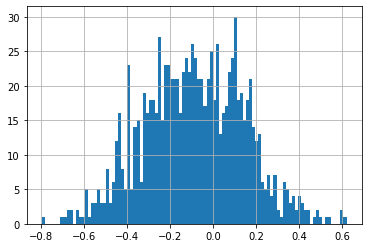

In [21]:
print('Avg. mean return:',np.mean(mean_returns))
print('Avg. volatility:',np.mean(volatilities))
print('Avg. Sharpe:',np.mean(sharpes))
pd.Series(sharpes).hist(bins=100)